<a href="https://colab.research.google.com/github/jimzhang629/RippleNet/blob/master/edited_RippleNet_timeseries_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RippleNet_timeseries_prediction
Plotting codes for manuscript figures 1A, 8-11 in E. Hagen, A.R. Chambers, G.T. Einevoll, K.H.Pettersen, R. Enger and A.J. Stasik (2020). 

Author: Espen Hagen (<https://github.com/espenhgn>)

LICENSE: <https://github.com/CINPLA/RippleNet/blob/master/LICENSE>

In [1]:
# allow running on Google Colab, using data on Google Drive
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd gdrive/My\ Drive/RippleNet
    %tensorflow_version 2.x
except:
    pass

Mounted at /content/gdrive
/content/gdrive/My Drive/RippleNet


In [2]:
%matplotlib inline

In [3]:
import os
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tensorflow
import tensorflow as tf
from tensorflow import keras
import h5py # TODO: use tensorflow.keras.utils.HDF5Matrix
from matplotlib import colors
import seaborn as sns
import pandas as pd
import pickle
from ripplenet.common import *

In [4]:
plt.rcParams.update({'figure.max_open_warning': 100})
plt.rcParams.update(rcParams)

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14576967542484595937
]


In [6]:
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.4.1

Num GPUs Available:  0


In [7]:
# fix seeds
np.random.seed(1234)
tf.random.set_seed(12345)

In [8]:
# create folder for figure files
if not os.path.isdir('figures'):
    os.mkdir('figures')

# Predictions on continuous timeseries

## load neural network from file

In [9]:
# choose the epoch giving the best performance on validation set, or last training epoch
best = '' #'best_' or '' 

model_files = [
    os.path.join('trained_networks', 'ripplenet_unidirectional_{}random_seed201.h5'.format(best)),
    os.path.join('trained_networks', 'ripplenet_unidirectional_{}random_seed202.h5'.format(best)),
    os.path.join('trained_networks', 'ripplenet_unidirectional_{}random_seed203.h5'.format(best)),
    os.path.join('trained_networks', 'ripplenet_unidirectional_{}random_seed204.h5'.format(best)),
    os.path.join('trained_networks', 'ripplenet_unidirectional_{}random_seed205.h5'.format(best)),
    os.path.join('trained_networks', 'ripplenet_unidirectional_{}random_seed206.h5'.format(best)),
]
losses_files = [
    os.path.join('trained_networks', 'ripplenet_unidirectional_history_random_seed201.pkl'),
    os.path.join('trained_networks', 'ripplenet_unidirectional_history_random_seed202.pkl'),
    os.path.join('trained_networks', 'ripplenet_unidirectional_history_random_seed203.pkl'),
    os.path.join('trained_networks', 'ripplenet_unidirectional_history_random_seed204.pkl'),
    os.path.join('trained_networks', 'ripplenet_unidirectional_history_random_seed205.pkl'),
    os.path.join('trained_networks', 'ripplenet_unidirectional_history_random_seed206.pkl'),
]

In [10]:
model_files, losses_files

(['trained_networks/ripplenet_unidirectional_random_seed201.h5',
  'trained_networks/ripplenet_unidirectional_random_seed202.h5',
  'trained_networks/ripplenet_unidirectional_random_seed203.h5',
  'trained_networks/ripplenet_unidirectional_random_seed204.h5',
  'trained_networks/ripplenet_unidirectional_random_seed205.h5',
  'trained_networks/ripplenet_unidirectional_random_seed206.h5'],
 ['trained_networks/ripplenet_unidirectional_history_random_seed201.pkl',
  'trained_networks/ripplenet_unidirectional_history_random_seed202.pkl',
  'trained_networks/ripplenet_unidirectional_history_random_seed203.pkl',
  'trained_networks/ripplenet_unidirectional_history_random_seed204.pkl',
  'trained_networks/ripplenet_unidirectional_history_random_seed205.pkl',
  'trained_networks/ripplenet_unidirectional_history_random_seed206.pkl'])

In [11]:
# fill up models and losses containers
models = []
losses = []
for i, (mf, pf) in enumerate(zip(model_files, losses_files)):
    models.append(keras.models.load_model(mf))
    with open(pf, 'rb') as f:
        losses.append(pickle.load(f))

## load a session time series

In [35]:
# some needed parameters
Fs = 1250 # Hz, sampling freq

# width of boxcar around each labeled event
y_label_width = int(50 * Fs / 1000) # 50 ms @ Fs

In [36]:
# default settings for detecting event from predictions
threshold = 0.5
distance = int(50 * Fs / 1000) # ms @ Fs, peak interdistance
width = int(20 * Fs / 1000) # ms @ Fs, peak width

In [37]:
# open file with complete time series
session = 'm4029_session1'  # holdout dataset
f = h5py.File(os.path.join('data', '{}.h5'.format(session)), 'r')

In [38]:
# list sessions:
list(f.items())

[('m4029_session1', <HDF5 group "/m4029_session1" (7 members)>)]

In [39]:
list(f[session].items())

[('S', <HDF5 dataset "S": shape (753914, 16), type "<f8">),
 ('S_freqs', <HDF5 dataset "S_freqs": shape (16,), type "<f8">),
 ('X1', <HDF5 dataset "X1": shape (753914,), type "<f8">),
 ('lfp', <HDF5 dataset "lfp": shape (753914,), type "<f8">),
 ('rippleLocs', <HDF5 dataset "rippleLocs": shape (86,), type "<i4">),
 ('run_speed', <HDF5 dataset "run_speed": shape (753914,), type "<i4">),
 ('y', <HDF5 dataset "y": shape (753914,), type "<f8">)]

## Run prediction on entire dataset

In [40]:
# load data (cont. LFP and ripple locations for plotting)
X0_cont = np.expand_dims(np.expand_dims(f[session]['lfp'][:], 0), -1) # input must have shape (n_samples, n_timesteps, 1)
rippleLocs = f[session]['rippleLocs'][:]
S_freqs = f[session]['S_freqs'][:]

print(X0_cont.shape)

(1, 753914, 1)


In [41]:
# imshow color limits
vmin, vmax = np.exp(np.percentile(np.log(f[session]['S'][:Fs*30, :].flatten()), [1, 99]))

In [42]:
# Switch or reshaping input into segments, or running on full time series
if False:
    # Predict using entire dataset at once (not recommended)
    Y_cont_preds = []
    for model in models:
        Y_cont_preds.append(model.predict(X0_cont))
else:
    # Reshape time axis to segments of some duration
    segment_length = int(0.5 * Fs) # Fs
    #segment_length = int(1 * Fs) # Fs

    # run predictions n times with shifts of length segment_length / n,
    # then final output will be averaged

    n = 5 # nicely divisible with Fs=1250
    shift = int(segment_length / n)
    
    Y_cont_preds = []

    for model in models:
      
      container = []

      for i in range(n):
          X0_cont_padded = np.concatenate((np.zeros((1, i * shift, 1)), X0_cont), axis=1)

          # pad with zeros 
          X0_cont_padded = np.concatenate((X0_cont_padded, 
                                          np.zeros((1, segment_length - 
                                                    (X0_cont_padded.size % segment_length), 1))), 
                                          axis=1)
          
          # reshape into segments of length  
          X0_cont_padded = X0_cont_padded.reshape((-1, segment_length, 1))

          # run prediction on data
          
          Y_cont_pred = model.predict(X0_cont_padded)

          # Reshape to zero-padded size
          Y_cont_pred = Y_cont_pred.reshape((1, -1, 1))[:, :X0_cont_padded.size, :]

          # strip elements that were padded with zeros
          container.append(Y_cont_pred[:, i * shift:i * shift + X0_cont.size, :])

      # average or median    
      Y_cont_pred = np.median(container, axis=0)
      Y_cont_preds.append(Y_cont_pred)

      # remove intermediate predictions
      del container
    
     
print(Y_cont_preds)

[array([[[0.0155111 ],
        [0.01539668],
        [0.01286617],
        ...,
        [0.03029779],
        [0.0273076 ],
        [0.03496087]]], dtype=float32), array([[[0.00917026],
        [0.00763297],
        [0.0064781 ],
        ...,
        [0.00358039],
        [0.0037204 ],
        [0.00340259]]], dtype=float32), array([[[0.03999773],
        [0.03051105],
        [0.02089074],
        ...,
        [0.00398761],
        [0.0028317 ],
        [0.00217184]]], dtype=float32), array([[[0.00430307],
        [0.00364193],
        [0.00364456],
        ...,
        [0.0032303 ],
        [0.0038276 ],
        [0.00466841]]], dtype=float32), array([[[0.00287578],
        [0.00268614],
        [0.00233391],
        ...,
        [0.00381914],
        [0.00368267],
        [0.00305289]]], dtype=float32), array([[[0.00287592],
        [0.00320229],
        [0.00291389],
        ...,
        [0.00285333],
        [0.00233778],
        [0.0021354 ]]], dtype=float32)]


In [43]:
print(Y_cont_preds[0])

[[[0.0155111 ]
  [0.01539668]
  [0.01286617]
  ...
  [0.03029779]
  [0.0273076 ]
  [0.03496087]]]


In [44]:
# compare ground truth times vs. predicted times
peaks, _ = ss.find_peaks(Y_cont_pred[0, :, 0], height=threshold, distance=distance, width=width)

In [45]:
# remove ripple locations in movement periods (within 0.5s of movement event)
if 'run_speed' in list(f[session].keys()):
    # smoothen run_speed by 1s boxcar filter:
    run_speed = np.convolve(f[session]['run_speed'], ss.boxcar(Fs) / Fs, 'same')
    # keep ripples where run_speed == 0:
    peaks = peaks[run_speed[peaks] == 0]
else:
    run_speed = None

In [46]:
TPs, FPs, FNs, stats = get_TPs_FPs_FNs_stats(f[session]['y'][:].flatten(), 
                                             Y_cont_preds[1].flatten(), 
                                             f[session]['rippleLocs'][:], 
                                             threshold, distance, width,
                                             run_speed=run_speed,
                                             y_label_width=y_label_width)

In [51]:
df = pd.DataFrame(columns=['TP', 'FP', 'FN', 'FP+FN', 'F_1'], 
                  dtype='object')

for Y_cont_pred in Y_cont_preds:

  TPs, FPs, FNs, stats = get_TPs_FPs_FNs_stats(f[session]['y'][:].flatten(), 
                                             Y_cont_pred.flatten(), 
                                             f[session]['rippleLocs'][:], 
                                             threshold, distance, width,
                                             run_speed=run_speed,
                                             y_label_width=y_label_width) 
   
  df = pd.concat([df, stats], axis=0, ignore_index=True)

  #next step is to add a column of the network names

In [52]:
df

,TP,FP,FN,FP+FN,F_1,precision,recall
0,0,6,86,92,0,0.000,0.000
1,75,60,11,71,0.679,0.556,0.872
2,74,68,12,80,0.649,0.521,0.860
3,71,55,15,70,0.67,0.563,0.826
4,75,74,11,85,0.638,0.503,0.872
5,73,66,13,79,0.649,0.525,0.849


In [ ]:
for i in len(Y_cont_preds):

  TPs, FPs, FNs, stats = get_TPs_FPs_FNs_stats(f[session]['y'][:].flatten(), 
                                              Y_cont_preds[i].flatten(), 
                                              f[session]['rippleLocs'][:], 
                                              threshold, distance, width,
                                              run_speed=run_speed,
                                              y_label_width=y_label_width)
  #get this to output to row of PD dataframe later.

In [55]:
stats

,TP,FP,FN,FP+FN,precision,recall,F_1
0,75,60,11,71,0.556,0.872,0.679


In [ ]:
print(stats.to_latex(index=False))

\begin{tabular}{rrrrrrr}
\toprule
 TP &  FP &  FN &  FP+FN &  precision &  recall &    F\_1 \\
\midrule
 73 &  66 &  13 &     79 &      0.525 &   0.849 &  0.649 \\
\bottomrule
\end{tabular}



In [ ]:
# add label, marker and color to each event
labels = []
for p in peaks:
    if p in TPs:
        labels.append([p, 'TP', 'k', 'gray', 'D'])
    elif p in FPs:
        labels.append([p, 'FP', 'k', 'gray', '^'])
    else:
        raise NotImplementedError
for p in FNs:
    labels.append([p, 'FN', 'k', 'gray', 'v'])
labels = pd.DataFrame(labels, columns=['i', 'label', 'mec', 'mfc', 'marker'])

In [ ]:
# preview labels
labels

,i,label,mec,mfc,marker
0,1985,TP,k,gray,D
1,113135,FP,k,gray,^
2,123837,FP,k,gray,^
3,125248,TP,k,gray,D
4,135615,TP,k,gray,D
...,...,...,...,...,...
147,620173,FN,k,gray,v
148,620964,FN,k,gray,v
149,646018,FN,k,gray,v
150,699778,FN,k,gray,v


## Figure 9

In [ ]:
def plot_figure(X0, X1, S, y, y_pred, time, rippleLocs, inds, peaks, labels):
    fig = plt.figure(figsize=(12, 10))
    gs = GridSpec(5, 1, hspace=0.3, left=0.05, right=0.95, top=0.95, bottom=0.05)

    ax0 = fig.add_subplot(gs[0, 0])
    ax0.plot(time, X0 - X0.mean(), 'k', lw=0.5,  
            label='__nolabel__')

    ax0.plot(rippleTimes / Fs, X0[rippleTimes-inds.min()] - X0.mean() + 0.4, 
            'D', mec='k', mfc='w', label='SPW-R', ms=8, clip_on=False)    
    ax0.set_title(r'$X(t)$')
    ax0.set_ylabel('(mV)', labelpad=0)
    ax0.axis(ax0.axis('tight'))
    for spine in ['top', 'bottom', 'right']:
        ax0.spines[spine].set_visible(False)
    plt.setp(ax0.get_xticklabels(), visible=False)
    ax0.xaxis.set_ticks_position('none')
    ax0.legend(loc=(1, 0.2), frameon=False, handletextpad=0)
    annotate_subplot(ax0, ncols=3, nrows=5, letter='a')

    # band-pass filtered LFP
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax0)
    ax2.plot(time, X1, 'k', lw=0.5, label=r'$\phi_\mathrm{BP}(t)$')
    ax2.set_title(r'$\phi_\mathrm{BP}(t)$')
    ax2.axis(ax2.axis('tight'))
    ax2.set_ylabel('(mV)', labelpad=0)
    for spine in ['top', 'bottom', 'right']:
        ax2.spines[spine].set_visible(False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    ax2.xaxis.set_ticks_position('none')    
    annotate_subplot(ax2, ncols=3, nrows=5, letter='b')

    # spectrograms
    ax3 = fig.add_subplot(gs[2, 0], sharex=ax0)
    im = ax3.pcolormesh(time, S_freqs, S.T, 
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                        cmap='inferno',
                        label='spectrogram',
                        rasterized=True)
    rect = np.array(ax3.get_position().bounds)
    rect[0] += rect[2] + 0.01
    rect[2] = 0.01
    fig = plt.gcf()
    cax = fig.add_axes(rect)
    cbar = fig.colorbar(im, cax=cax, extend='both')
    cbar.set_ticks(10.**np.arange(-5, 5))
    cbar.set_label('(a.u.)', labelpad=0)
    ax3.axis(ax3.axis('tight'))
    ax3.set_title(r'$S(t, f)$')
    ax3.set_ylabel('$f$ (Hz)', labelpad=0)
    ax3.set_xlabel('$t$ (s)', labelpad=0)
    annotate_subplot(ax3, ncols=3, nrows=5, letter='c')
    
    # label vector
    ax1 = fig.add_subplot(gs[3, 0], sharex=ax0)    
    ax1.plot(time, y, 'k', lw=0.5, clip_on=False)
    ax1.set_ylabel(r'$y(t)$', labelpad=0)
    ax1.axis(ax1.axis('tight'))
    for spine in ['top', 'bottom', 'right']:
        ax1.spines[spine].set_visible(False)
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.xaxis.set_ticks_position('none')
    annotate_subplot(ax1, ncols=3, nrows=5, letter='d')
    ax1.set_yticks([0, 1])
    ax1.set_ylim(0, 1)

    # label vector prediction
    ax4 = fig.add_subplot(gs[4], sharex=ax0, sharey=ax1)    
    ax4.plot(time, y_pred, 'k', lw=0.5, clip_on=False, label='__nolabel__')
    #ax4.plot(time[peaks__], y_pred[peaks__]+0.1, 'kd', ms=8, clip_on=False)
    
    
    for lbl in np.unique(labels.label):
    #for _, row in labels.iterrows():
        ax4.plot(labels[labels.label==lbl].i.astype(int) / Fs, 
                 y_pred[labels[labels.label==lbl].i.astype(int)-inds.min()]+0.1, 
                 labels[labels.label==lbl].marker.values[0], 
                 mec=labels[labels.label==lbl].mec.values[0],
                 mfc=labels[labels.label==lbl].mfc.values[0],
                 ms=8, clip_on=False, 
                 label=lbl)

    ax4.legend(loc=(1., 0.2), frameon=False, handletextpad=0)

    
    ax4.plot([time[-1]-1, time[-1]-2], [-0.05, -0.05], 'k-', lw=1, clip_on=False)
    ax4.text(time[-1]-1.5, -0.1, '1 s', va='top', ha='center')

    
    ax4.set_ylabel(r'$\hat{y}(t)$', labelpad=0)
    ax4.axis(ax1.axis('tight'))
    ax4.set_ylim(0, 1)
    ax4.set_yticks([0, 1])
    for spine in ['top', 'bottom', 'right']:
        ax4.spines[spine].set_visible(False)
    plt.setp(ax4.get_xticklabels(), visible=False)
    ax4.xaxis.set_ticks_position('none')    
    ax4.set_xlim(time[0], time[-1])
    annotate_subplot(ax4, ncols=3, nrows=5, letter='e')

    return fig

In [ ]:
windowsize = Fs * 10

KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7ff0c124e950> (for post_execute):


KeyboardInterrupt: ignored

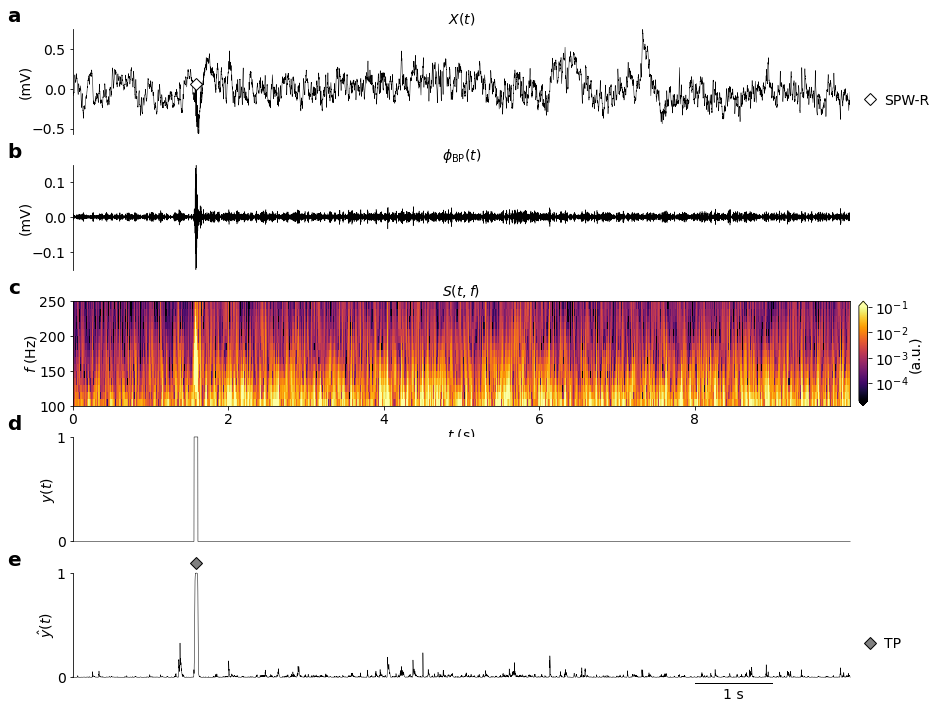

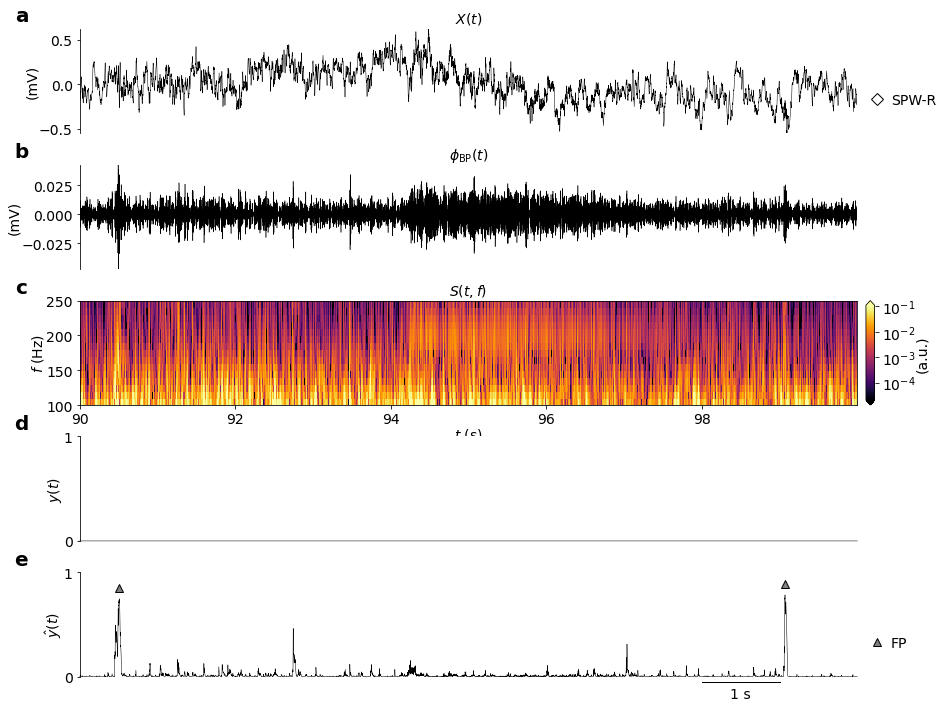

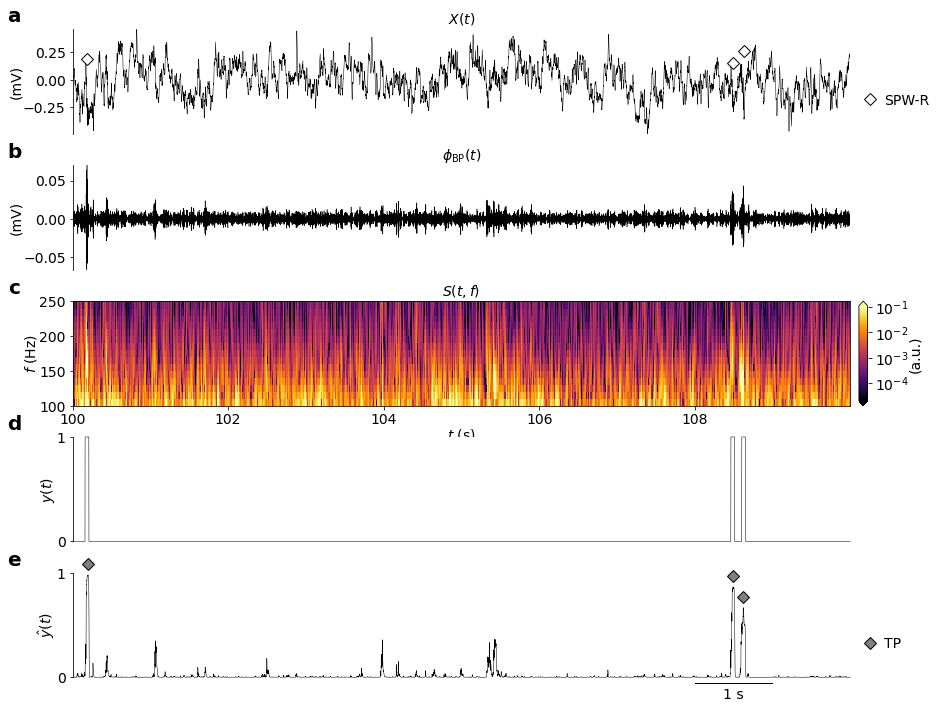

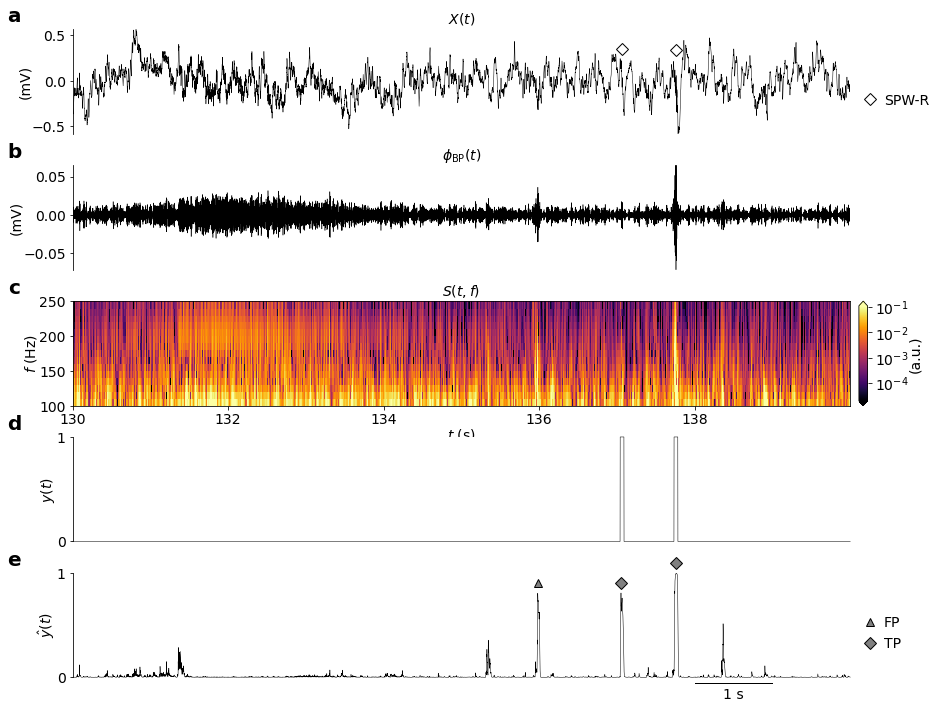

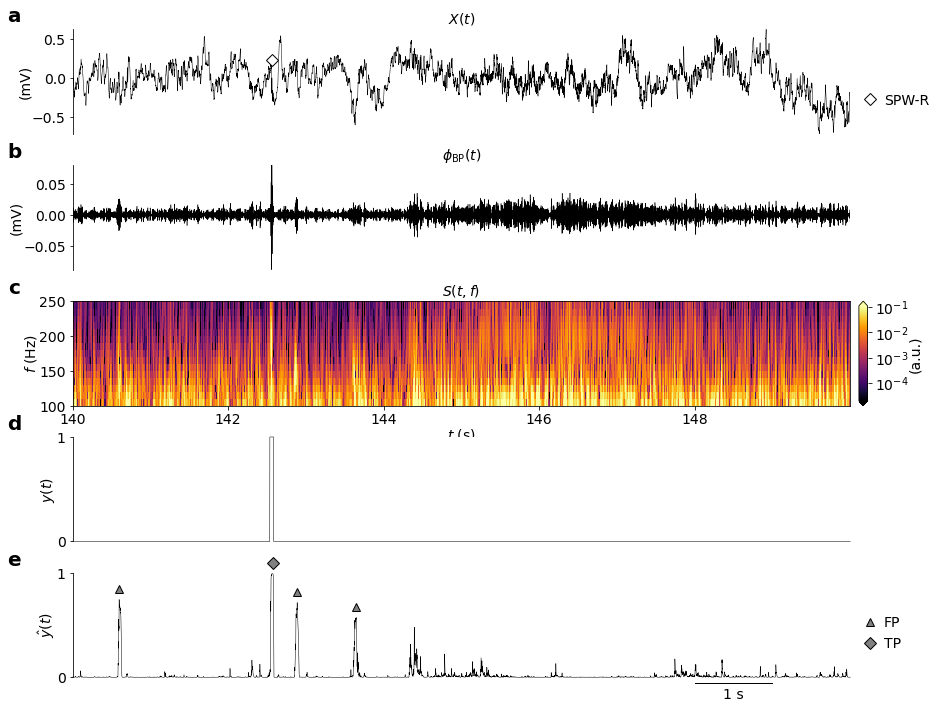

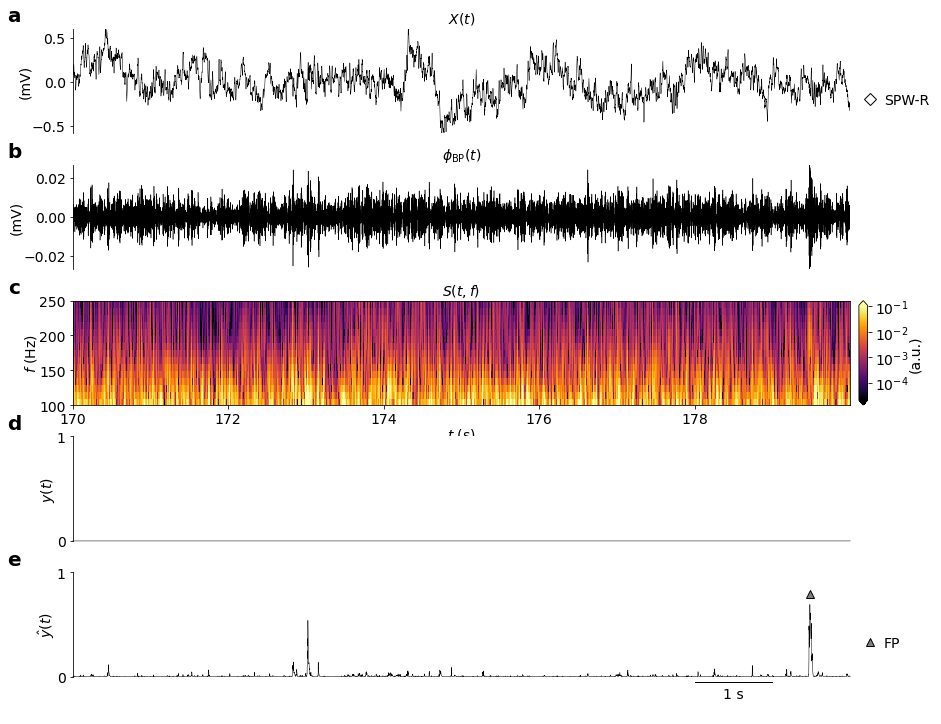

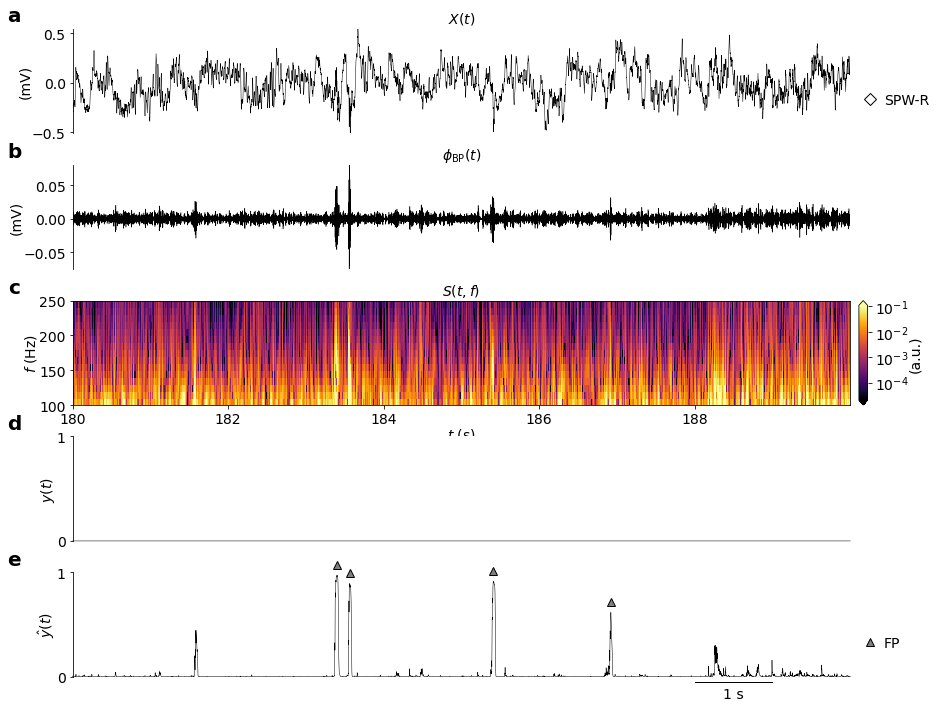

In [ ]:
for i in range(Y_cont_pred.size // windowsize):
    inds = np.arange(i*windowsize, windowsize*(i+1))
    time = inds / Fs

    X0 = f[session]['lfp'][:][inds]
    X1 = f[session]['X1'][:][inds]
    S = f[session]['S'][:][inds, ]
    y = f[session]['y'][:][inds]

    y_pred = Y_cont_pred.flatten()[inds]

    peaks__, _ = ss.find_peaks(y_pred, height=threshold, distance=distance, width=width)

    # keep ripples where run_speed == 0:
    peaks__ = peaks__[run_speed[inds][peaks__] == 0]
    
    rippleInds = (rippleLocs >= inds.min()) & (rippleLocs < inds.max())
    rippleTimes = rippleLocs[rippleInds]
    
    # skip plot if no events of any kinds are found in segment
    if (rippleTimes.size + peaks__.size) == 0:
        continue

    labels_ = labels[(labels.i >= inds.min()) & (labels.i < inds.max())] 

    fig = plot_figure(X0, X1, S, y, y_pred, time, rippleLocs, inds, peaks, labels_)
    
    # save figure
    fig.savefig(os.path.join('figures', 'figure09_{}s_{}s.pdf'.format(int(round(time[0])), 
                                                                      int(round(time[-1])))), 
                dpi=300, bbox_inches='tight', pad_inches=0.05)
    fig.savefig(os.path.join('figures', 'figure09_{}s_{}s.eps'.format(int(round(time[0])), 
                                                                      int(round(time[-1])))), 
                dpi=300, bbox_inches='tight', pad_inches=0.05)
    #plt.close(fig)

## Figure 10

In [ ]:
# compare cumulative counts of events for session
onehot_pred = np.zeros(Y_cont_pred.size)
onehot_pred[peaks] = 1
onehot = np.zeros(Y_cont_pred.size)
onehot[rippleLocs] = 1

In [ ]:
# correlation function between rippleLocs and peaks
bin_size = 2.5 # 2 ms at Fs=1250 Hz
n_lags = 50 # 

bin_count = X0_cont.size // bin_size
if (X0_cont.size % bin_size) > 0:
    bin_count += 1
bins = np.arange(bin_count) * bin_size + bin_size / 2

labels_binned, _ = np.histogram(rippleLocs, bins=bins)
preds_binned, _ = np.histogram(peaks, bins=bins)

Cxy = np.correlate(labels_binned-labels_binned.mean(), 
                    preds_binned-preds_binned.mean(), 'same')[::-1] / \
                        (labels_binned.std() * preds_binned.std() * preds_binned.size) 

lags = (bins - Cxy.size // 2 * bin_size) / Fs * 1000
lag_inds = np.arange(n_lags) + lags.size // 2 - n_lags // 2 - 1

In [ ]:
def get_samples(f, session, inds, lag):

    # create arrays of training and validation samples combining data from all sessions
    X0 = [] # container for raw data segments
    X1 = [] # container for gamma-band data segments
    S = []  # container for specgram
    Y = []  # container for labels
    labels = [] # data labels (session, rippleLoc, offset)

    sample_size = lag * 2 + 1

    for ind in inds:
        # center segments on event
        offset = -sample_size // 2        
        
        # extract
        idx = np.arange(sample_size) + ind + offset
        if idx.min() < 0:
            idx -= idx.min()
        elif idx.max() >= f[session]['lfp'].size:
            idx = idx - (idx.max() - f[session]['lfp'].size + 1) 
        X0.append(f[session]['lfp'][:][idx])
        X1.append(f[session]['X1'][:][idx])
        S.append(f[session]['S'][:][idx, ])
        labels.append((session, ind, offset))

    # convert to numpy arrays, downcast to single precision
    X0 = np.array(X0).astype(np.float32)
    X1 = np.array(X1).astype(np.float32)
    S = np.array(S).astype(np.float32)
    labels = np.array(labels, dtype=[('session', 'S16'), ('rippleLocs', np.int32), ('offset', np.int32)])

    return X0, X1, S, labels

In [ ]:
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(2,3, left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.3, hspace=0.3)

# cumulative counts
ax = fig.add_subplot(gs[0, 0])
ax.plot(onehot.cumsum(), onehot_pred.cumsum())
ax.set_xlabel('# labeled SPW-R', labelpad=0)
ax.set_ylabel('# pred. SPW-R', labelpad=0)
annotate_subplot(ax, ncols=10, nrows=2, letter='a')

# correlation function
ax = fig.add_subplot(gs[1, 0])
#ax.step(lags[lag_inds], Cxy[lag_inds], where='mid')
ax.fill_between(lags[lag_inds], Cxy[lag_inds], step='pre')
ax.set_xlabel(r'$\tau$ (ms)', labelpad=0)
ax.set_ylabel(r'$\rho_{y\hat{y}}(\tau)$', labelpad=0)
annotate_subplot(ax, ncols=10, nrows=2, letter='b')

# energy vs (1-y)
ax0 = fig.add_subplot(gs[0, 1])
ax1 = fig.add_subplot(gs[1, 1], sharex=ax0, sharey=ax0)

lag = int(100 * Fs / 1000) # 100 ms @ Fs
y_max_labeled = Y_cont_pred[0, rippleLocs + np.expand_dims(np.arange(-31, 32), -1), 0].max(axis=0)
y_max_pred = Y_cont_pred[0, peaks, 0]
E_s = []
for j, (inds, confidence, marker, label, ax) in enumerate(zip([rippleLocs, peaks], 
                                                          [y_max_labeled, y_max_pred], 
                                                          ['.', '.'],
                                                          [r'$y$', r'$\hat{y}$'],
                                                          [ax0, ax1] 
                                                         )):
    _, X1_, _, _ = get_samples(f, session, inds, lag)
    # energy measure
    E_s.append(np.sum(X1_**2, axis=1))
    sns.kdeplot(np.log10(1-confidence), np.log10(E_s[-1]), ax=ax, cbar=False, shade=False)
    ax.plot(np.log10(1-confidence), np.log10(E_s[-1]), marker, ms=8, alpha=1, label=label)
    ax.set_ylabel(r'$\log_{10}(E_s^{\langle j \rangle})$', labelpad=0)
xvals = np.log10(1-np.r_[y_max_labeled, y_max_pred])
yvals = np.log10(np.r_[E_s[0], E_s[1]])
ax1.set_xlim(xvals.min(), xvals.max())
ax1.set_ylim(yvals.min(), yvals.max())
ax1.set_xlabel(r'$\log_{10}(1-\hat{y}^{\langle j \rangle})$', labelpad=0)
annotate_subplot(ax0, ncols=8, nrows=2, letter='c')


# averaged SPW-R spectrograms
time = np.arange(-lag, lag+1) / Fs * 1000
for j, inds in enumerate([rippleLocs, peaks]): 
    X0_, X1_, S_, labels_ = get_samples(f, session, inds, lag)

    ax = fig.add_subplot(gs[j, 2])

    #vmin, vmax = np.exp(np.percentile(np.log(S_cont.flatten()), [1, 99]))
    im = ax.pcolormesh(time, S_freqs, S_.mean(axis=0).T, 
                       norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                       cmap='inferno',
                       label='spectrogram',
                       rasterized=True)
    #if j == 1:
    rect = np.array(ax.get_position().bounds)
    rect[0] += rect[2] + 0.01
    rect[2] = 0.01
    fig = plt.gcf()
    cax = fig.add_axes(rect)
    
    cbar = fig.colorbar(im, cax=cax, extend='both')
    cbar.set_ticks(10.**np.arange(-5, 5))
    cbar.set_label('(a.u.)', labelpad=0)
    ax.axis(ax.axis('tight'))
    ax.set_ylabel('$f$ (Hz)', labelpad=0)
    if j == 1:
        ax.set_xlabel(r'$\tau$ (ms)', labelpad=0)
    if j == 0:
        annotate_subplot(ax, ncols=8, nrows=2, letter='d')

# save figure
fig.savefig(os.path.join('figures', 'figure10.pdf'), dpi=300, bbox_inches='tight', pad_inches=0.05)
fig.savefig(os.path.join('figures', 'figure10.eps'), dpi=300, bbox_inches='tight', pad_inches=0.05)

## Compare SPW-R predictions to labeled events
input, filtered LFPs, spectrograms

In [ ]:
n_samples = 8
lag = int(100 * Fs / 1000) # 100 ms @ Fs
time = np.arange(-lag, lag+1) / Fs * 1000

In [ ]:
# plot labeled ripple events with scores by the RippleNet 
n_plots = rippleLocs.size // 10
if rippleLocs.size % 10 > 0:
    n_plots += 1

# get scoring at times of labeled rippleLocs
confidence = Y_cont_pred[0, rippleLocs + np.expand_dims(np.arange(-31, 32), -1), 0].max(axis=0) 
sort = np.argsort(confidence)[::-1]

#for k in range(n_plots):
#    inds_labeled = rippleLocs[sort][k*n_samples:(k+1)*n_samples]
#    conf_labeled = confidence[sort][k*n_samples:(k+1)*n_samples]
#    j_super = np.arange(rippleLocs.size)[sort][k*n_samples:(k+1)*n_samples]

# plot only the n_samples best and worst examples
for k, inds in enumerate([np.arange(rippleLocs.size)[:n_samples], 
                          np.arange(rippleLocs.size)[-n_samples:]]):
    inds_labeled = rippleLocs[sort][inds]
    conf_labeled = confidence[sort][inds]
    j_super = np.arange(rippleLocs.size)[sort][inds]

    for j, (inds, dataset) in enumerate(zip([inds_labeled], ['labeled'])): 
        fig, axes = plt.subplots(3, n_samples, figsize=(12, 6), sharex=True, sharey='row')
        fig.subplots_adjust(left=0.09, bottom=0.08, top=0.95)
        X0_, X1_, S_, labels_ = get_samples(f, session, inds, lag)

        for i in range(n_samples):
            # raw LFP with ripple label
            ax0 = axes[0, i]
            try:
                ax0.plot(time, X0_[i, ] - X0_[i, ].mean(), 'k', lw=0.5,  
                        label=r'$X^{\langle' + '{}'.format(i+1) + r'\rangle}(t)$')
            except IndexError:
                for ax in axes[:, i]:
                    ax.axis('off')
                continue

            if i == 0:
                ax0.set_ylabel('(mV)', labelpad=0)
            ax0.axis(ax0.axis('tight'))
            for spine in ['top', 'right']:
                ax0.spines[spine].set_visible(False)
            ax0.set_title(r'$\hat{y}^{\langle ' + str(np.where(rippleLocs==inds[i])[0][0]) + 
                          r' \rangle}=' + '{:.2f}'.format(conf_labeled[i].max()) + r'$')


            # band-pass filtered LFP
            ax2 = axes[1, i]
            ax2.plot(time, X1_[i, ], 'k', lw=0.5, label=r'$\phi_\mathrm{BP}(t)$')
            ax2.axis(ax2.axis('tight'))
            if i == 0:
                ax2.set_ylabel('(mV)', labelpad=0)
            for spine in ['top', 'right']:
                ax2.spines[spine].set_visible(False)
            
            ax3 = axes[2, i]
            im = ax3.pcolormesh(time, S_freqs, S_[i, ].T, 
                                norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                                cmap='inferno',
                                label='spectrogram',
                                rasterized=True)
            if i == n_samples-1:
                rect = np.array(ax3.get_position().bounds)
                rect[0] += rect[2] + 0.01
                rect[2] = 0.01
                fig = plt.gcf()
                cax = fig.add_axes(rect)

                cbar = fig.colorbar(im, cax=cax, extend='both')
                cbar.set_ticks(10.**np.arange(-5, 5))
                cbar.set_label('(a.u.)', labelpad=0)
            ax3.axis(ax3.axis('tight'))
            ax3.set_xticklabels([-100, 0])
            if i == 0:
                ax3.set_ylabel('$f$ (Hz)', labelpad=0)
            ax3.set_xlabel(r'$\tau$ (ms)', labelpad=0)

    # save figure
    fig.savefig(os.path.join('figures', 'figure11_{}.pdf'.format(k)), 
                dpi=300) #, bbox_inches='tight', pad_inches=0.05)
    fig.savefig(os.path.join('figures', 'figure11_{}.eps'.format(k)), 
                dpi=300) #, bbox_inches='tight', pad_inches=0.05)

In [ ]:
# Draw input and spectrograms for predictions, sort accd. to confidence (highest first).  
n_plots = peaks.size // 10
if peaks.size % 10 > 0:
    n_plots += 1

confidence = Y_cont_pred[0, peaks, 0]
sort = np.argsort(confidence)[::-1]

#for k in range(n_plots):
#    inds_pred = peaks[sort][k*n_samples:(k+1)*n_samples]
#    conf_pred = confidence[sort][k*n_samples:(k+1)*n_samples]
#    label_labeled = labels.loc[sort][k*n_samples:(k+1)*n_samples]
#    j_super = np.arange(peaks.size)[sort][k*n_samples:(k+1)*n_samples]

# plot only the n_samples best and worst examples
for k, inds in enumerate([np.arange(peaks.size)[:n_samples], 
                          np.arange(peaks.size)[-n_samples:]]):
    inds_pred = peaks[sort][inds]
    conf_pred = confidence[sort][inds]
    label_labeled = labels.loc[sort].reset_index().loc[inds] #labels.loc[sort][inds]
    j_super = np.arange(peaks.size)[sort][inds]

    for j, (inds, dataset) in enumerate(zip([inds_pred], ['predicted'])): 
        fig, axes = plt.subplots(3, n_samples, figsize=(12, 6), sharex=True, sharey='row')
        fig.subplots_adjust(left=0.09, bottom=0.08, top=0.95)
        X0_, X1_, S_, labels_ = get_samples(f, session, inds, lag)

        for i in range(n_samples):
            # raw LFP with ripple label
            ax0 = axes[0, i]
            try:
                ax0.plot(time, X0_[i, ] - X0_[i, ].mean(), 'k', lw=0.5,  
                        label=r'$X^{\langle' + '{}'.format(i+1) + r'\rangle}(t)$')
            except IndexError:
                for ax in axes[:, i]:
                    ax.axis('off')
                continue
                
            if i == 0:
                ax0.set_ylabel('(mV)', labelpad=0)
            ax0.axis(ax0.axis('tight'))
            for spine in ['top', 'right']:
                ax0.spines[spine].set_visible(False)
            ax0.set_title(r'$\hat{y}^{\langle ' + str(j_super[i]) + 
                          r' \rangle}=' + '{:.2f}'.format(conf_pred[i]) + r'$')

            # band-pass filtered LFP
            ax2 = axes[1, i]
            ax2.plot(time, X1_[i, ], 'k', lw=0.5, label=r'$\phi_\mathrm{BP}(t)$')
            ax2.axis(ax2.axis('tight'))
            if i == 0:
                ax2.set_ylabel('(mV)', labelpad=0)
            for spine in ['top', 'right']:
                ax2.spines[spine].set_visible(False)
            
            ax2.set_title(label_labeled.label.values[i], 
                          color=label_labeled.color.values[i])

            
            ax3 = axes[2, i]
            im = ax3.pcolormesh(time, S_freqs, S_[i, ].T, 
                                norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                                cmap='inferno',
                                label='spectrogram',
                                rasterized=True)
            if i == n_samples-1:
                rect = np.array(ax3.get_position().bounds)
                rect[0] += rect[2] + 0.01
                rect[2] = 0.01
                fig = plt.gcf()
                cax = fig.add_axes(rect)
                
                cbar = fig.colorbar(im, cax=cax, extend='both')
                cbar.set_ticks(10.**np.arange(-5, 5))
                cbar.set_label('(a.u.)', labelpad=0)
            ax3.axis(ax3.axis('tight'))
            ax3.set_xticklabels([-100, 0])
            if i == 0:
                ax3.set_ylabel('$f$ (Hz)', labelpad=0)
            ax3.set_xlabel(r'$\tau$ (ms)', labelpad=0)

        # save figure
        fig.savefig(os.path.join('figures', 'figure12_{}.pdf'.format(k)), 
                    dpi=300) #, bbox_inches='tight', pad_inches=0.05)
        fig.savefig(os.path.join('figures', 'figure12_{}.eps'.format(k)), 
                    dpi=300) #, bbox_inches='tight', pad_inches=0.05)

In [ ]:
# panel A for figure 1 

In [ ]:
confidence = Y_cont_pred[0, peaks, 0]
sort = np.argsort(confidence)[::-1]

k = 0
inds = np.array([0])

inds_pred = peaks[sort][inds]
conf_pred = confidence[sort][inds]
label_labeled = labels.loc[sort].reset_index().loc[inds] #labels.loc[sort][inds]
j_super = np.arange(peaks.size)[sort][inds]


inds = inds_pred

fig = plt.figure(figsize=(2,4))
gs = GridSpec(3, 1, hspace=0.3)

X0_, X1_, S_, labels_ = get_samples(f, session, inds, lag)

i = 0

# raw LFP with ripple label
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(time, X0_[i, ] - X0_[i, ].mean(), 'k', lw=0.5,  
        label=r'$X^{\langle' + '{}'.format(i+1) + r'\rangle}(t)$')
ax0.set_ylabel('(mV)', labelpad=0)
ax0.axis(ax0.axis('tight'))
for spine in ['top', 'right', 'bottom']:
    ax0.spines[spine].set_visible(False)
ax0.set_xticks([])
ax0.set_xticklabels([])
ax0.set_title('LFP/SPW-R')
annotate_subplot(ax0, ncols=10, nrows=8, letter='a')

# band-pass filtered LFP
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(time, X1_[i, ], 'k', lw=0.5, label=r'$\phi_\mathrm{BP}(t)$')
ax2.axis(ax2.axis('tight'))
ax2.set_ylabel('(mV)', labelpad=0)
for spine in ['top', 'right', 'bottom']:
    ax2.spines[spine].set_visible(False)
ax2.set_xticks([])
ax2.set_xticklabels([])
ax2.set_title(r'$150-250$ Hz SPW-R')


# spectrogram
#ax3 = axes[2]
ax3 = fig.add_subplot(gs[2:, 0])
vmin, vmax_ = np.exp(np.percentile(np.log(f[session]['S'][:Fs*30, :].flatten()), [1, 99.9]))
#levels = np.linspace(vmin, vmax_, 20)
im = ax3.pcolormesh(time, S_freqs, S_[i, ].T, 
                    norm=colors.LogNorm(vmin=vmin, vmax=vmax_),
                    cmap='inferno',
                    label='spectrogram',
                    #levels=levels,
                    rasterized=True)
rect = np.array(ax3.get_position().bounds)
rect[0] += rect[2] + 0.01
rect[2] = 0.05
fig = plt.gcf()
cax = fig.add_axes(rect)

cbar = fig.colorbar(im, cax=cax, extend='both')
cbar.set_ticks(10.**np.arange(-5, 5))
cbar.set_label('(a.u.)', labelpad=0)
ax3.axis(ax3.axis('tight'))
if i == 0:
    ax3.set_ylabel('$f$ (Hz)', labelpad=0)
ax3.set_xlabel(r'$\tau$ (ms)', labelpad=0)
ax3.set_title('SPW-R spectrogram')

# save figure
# fig.savefig(os.path.join('figures', 'figure1A.pdf'), 
#             dpi=300, bbox_inches='tight', pad_inches=0.0)
# fig.savefig(os.path.join('figures', 'figure1A.eps'), 
#             dpi=300, bbox_inches='tight', pad_inches=0.0)

## Panel B:

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 8))
annotate_subplot(ax, ncols=1, nrows=1, letter='b')
ax.axis('off')

ms = 12  # marker size
n_samples = 11

for i, l in enumerate(model._layers):
    if l._name.rfind('input') >= 0:
        marker = 'o'
        color = 'k'
        ls = ''
        name = 'Input'
    elif l._name.rfind('gaussian_noise') >= 0:
        marker = 'P'
        color = 'gray'
        ls = ''
        name = 'Gaussian'
    elif l._name.rfind('conv1d') >= 0:
        marker = '*'
        color = 'k'
        ls = ''
        name = 'Conv1D'
    elif l._name.rfind('LSTM') >= 0:
        marker = '>'
        color = 'C0'
        ls = ''
        name = 'LSTM'
    elif l._name.rfind('bidir') >= 0:
        marker = '><'
        color = 'C0'
        ls = ''
        name = 'Bidir(LSTM)'
    elif l._name.rfind('time_distributed') >= 0:
        marker = 'D'
        color = 'k'
        ls = ''
        name = 'TimeDistributed(Dense)'
    elif l._name.rfind('dropout') >= 0:
        marker = '$D$'
        color = 'gray'
        ls = ''
        name = 'Dropout'
    elif l._name.rfind('batch_normalization') >= 0:
        marker = '$N$'
        color = 'gray'
        ls = ''
        name = 'BatchNorm'
    elif l._name.rfind('activation') >= 0:
        marker = 'X'
        color = 'gray'
        ls = ''
        name = 'Activation(ReLu)'
    else:
        raise NotImplementedError
        marker = '.'
        color = 'gray'
        ls = ''
        name = 'none'
    
    # 'node' position along time axis
    xpos = np.arange(n_samples) - (n_samples // 2)
    ypos = np.zeros(n_samples) + i
    
    # draw vertices across layers
    source_x = xpos
    target_x = xpos
    source_y = ypos
    target_y = ypos + 1
    for (sx, sy, tx, ty) in zip(source_x, source_y, target_x, target_y):
        ax.plot([sx, tx], [sy, ty], '-', 
                color='gray', lw=0.5, zorder=-1, clip_on=False)
    if name.rfind('LSTM') >= 0:
        ax.plot([-n_samples/2, n_samples/2], [i, i], '-',
                 color='gray', lw=0.5, zorder=-1, clip_on=False)
    
    if name in ['Input']:
        for (sx, sy, tx, ty) in zip(source_x, source_y-1, target_x, target_y-1):
            ax.plot([sx, tx], [sy, ty], '-', 
                    color='gray', lw=0.5, zorder=-1, clip_on=False)
    
    # draw horizontal box with width corresponding to # samples
    if name in ['Input', 'Conv1D', 'TimeDistributed(Dense)']:
        if isinstance(l.input_shape, tuple):
            for j in range(l.output_shape[-1]):
                if j == 0:
                    rect = plt.Rectangle((-(n_samples / 2) - 0.25, i-0.25), n_samples + 0.5, 0.5, 
                                         clip_on=False)
                    ax.add_patch(rect)
                else:
                    rect = plt.Rectangle((-(n_samples / 2) - 0.25 + j*0.01, i-0.25+j*0.01), 
                                         n_samples + 0.5, 0.5, 
                                         zorder=-j,
                                         fc='gray',
                                         clip_on=False)
                    ax.add_patch(rect)
        else:
            rect = plt.Rectangle((-(n_samples / 2) - 0.25, i-0.25), n_samples + 0.5, 0.5, clip_on=False)
            ax.add_patch(rect)
    else:
        if name in ['Bidir(LSTM)']:
            for j in range(l.output_shape[-1] // 2):
                if j == 0:
                    colorj = color
                else:
                    colorj = 'gray'
                ax.plot(xpos + j*0.01, ypos + j*0.01, 
                        ls=ls, color=colorj, marker=marker[0], ms=ms, zorder=-j, clip_on=False)
                xy_offset = 0.25
                ax.plot(xpos + xy_offset + j*0.01, ypos + xy_offset + j*0.01,
                        ls=ls, color=colorj, marker=marker[1], ms=ms, zorder=-j, clip_on=False)
            ax.plot([-n_samples / 2 + xy_offset, n_samples / 2 + xy_offset], 
                    [i + xy_offset, i + xy_offset], 
                    ls=':', color='gray', lw=0.5, zorder=-1, clip_on=False)
            for (sx, sy) in zip(source_x + xy_offset, source_y):
                ax.plot([sx, sx], [sy - 0.5 + xy_offset, sy + 0.5 + xy_offset], ':', 
                        color='gray', lw=0.5, zorder=-1, clip_on=False)
        elif name in ['LSTM']:
            for j in range(l.output_shape[-1] // 2):
                if j > 0:
                    color='gray'
                ax.plot(xpos + j*0.01, ypos + j*0.01, 
                        ls=ls, color=color, marker=marker, ms=ms, zorder=-j, clip_on=False)
        else:
            ax.plot(xpos, ypos, 
                    ls=ls, color=color, marker=marker, ms=ms, clip_on=False)
        
    # layer names
    if isinstance(l.input_shape, tuple):
        ax.text(n_samples / 2 + 0.5 , i, 
                name + r'$^{(N,%s)}$' % (l.output_shape[-1]), 
                va='center', clip_on=False)
    elif isinstance(l.input_shape, list):
        ax.text(n_samples / 2 + 0.5, i, 
                name + r'$_{(N,%s)}^{(N,%s)}$' % (l.input_shape[0][-1], l.output_shape[0][-1]), 
                va='center', clip_on=False)

# plot input/output prediction data labels
for i in range(- (n_samples // 2), n_samples // 2 + 1):
    if i < 0:
        xstring = r'$X^{\langle n-%s \rangle}$' % str(abs(i))
    elif i == 0:
        xstring = r'$X^{\langle n \rangle}$'
    else:
        xstring = r'$X^{\langle n+%s \rangle}$' % str(i)
    ystring = xstring.replace('X', '\hat{y}')
    
    ax.text(i, -1, xstring, ha='center', va='center')
    ax.text(i, len(model.layers), ystring, ha='center', va='center')

# plot input LFP trace
i = 0
x_trace = X0_[i, ] - X0_[i, ].mean() - 2
ax.plot(time / time.max() * (n_samples // 2 + 1), x_trace, 'k', lw=1, clip_on=False)
ax.text((n_samples // 2 + 1), -2, r'$X(t)$')

# plot output prediction
y_hat = Y_cont_pred[:, inds[0]-lag:inds[0] + lag + 1, :].flatten()
ax.plot(time / time.max() * (n_samples // 2 + 1), y_hat + len(model.layers) + 1, 'k', lw=1, clip_on=False)
ax.text((n_samples // 2 + 1), len(model.layers) + 1, r'$\hat{y}(t)$')

# additional lines
for i in range(-(n_samples // 2), n_samples // 2 + 1):
    ax.plot([time[lag + i] / time.max() * (n_samples // 2 + 1), i], [x_trace[lag + i], -1],
            '-', color='gray', lw=0.5, zorder=-1)
    ax.plot([time[lag + i] / time.max() * (n_samples // 2 + 1), i], 
            [y_hat[lag + i] + len(model.layers) + 1, len(model.layers)],
            '-', color='gray', lw=0.5, zorder=-1)
ax.set_xlim(-(n_samples / 2)-0.5, n_samples / 2 + 3)

# Figure 1


In [ ]:
fig = plt.figure(figsize=(12, 7))
gs = GridSpec(3, 9, hspace=0.3, wspace=-0.1)

i = 0

# raw LFP with ripple label
ax0 = fig.add_subplot(gs[0, :2])
ax0.plot(time, X0_[i, ] - X0_[i, ].mean(), 'k', lw=0.5,  
        label=r'$X^{\langle' + '{}'.format(i+1) + r'\rangle}(t)$')
ax0.set_ylabel('(mV)', labelpad=0)
ax0.axis(ax0.axis('tight'))
for spine in ['top', 'right', 'bottom']:
    ax0.spines[spine].set_visible(False)
ax0.set_xticks([])
ax0.set_xticklabels([])
ax0.set_title('LFP/SPW-R')
annotate_subplot(ax0, ncols=10, nrows=8, letter='a')

# band-pass filtered LFP
ax2 = fig.add_subplot(gs[1, :2])
ax2.plot(time, X1_[i, ], 'k', lw=0.5, label=r'$\phi_\mathrm{BP}(t)$')
ax2.axis(ax2.axis('tight'))
ax2.set_ylabel('(mV)', labelpad=0)
for spine in ['top', 'right', 'bottom']:
    ax2.spines[spine].set_visible(False)
ax2.set_xticks([])
ax2.set_xticklabels([])
ax2.set_title(r'$150-250$ Hz SPW-R')
annotate_subplot(ax2, ncols=10, nrows=8, letter='b')


# spectrogram
#ax3 = axes[2]
ax3 = fig.add_subplot(gs[2, :2])
vmin, vmax_ = np.exp(np.percentile(np.log(f[session]['S'][:Fs*30, :].flatten()), [1, 99.9]))
#levels = np.linspace(vmin, vmax_, 20)
im = ax3.pcolormesh(time, S_freqs, S_[i, ].T, 
                    norm=colors.LogNorm(vmin=vmin, vmax=vmax_),
                    cmap='inferno',
                    label='spectrogram',
                    #levels=levels,
                    rasterized=True)
rect = np.array(ax3.get_position().bounds)
rect[0] += rect[2] + 0.002
rect[2] = 0.015
fig = plt.gcf()
cax = fig.add_axes(rect)

cbar = fig.colorbar(im, cax=cax, extend='both', aspect=1)
cbar.set_ticks(10.**np.arange(-5, 5))
cbar.set_label('(a.u.)', labelpad=0)
ax3.axis(ax3.axis('tight'))
if i == 0:
    ax3.set_ylabel('$f$ (Hz)', labelpad=0)
ax3.set_xlabel(r'$\tau$ (ms)', labelpad=0)
ax3.set_title('SPW-R spectrogram')
annotate_subplot(ax3, ncols=10, nrows=8, letter='c')



##############################################
ax = fig.add_subplot(gs[:, 3:])

annotate_subplot(ax, ncols=1, nrows=2.5, letter='d')
ax.axis('off')

ms = 12  # marker size
n_samples = 7 # number of time samples

for i, l in enumerate(model._layers):
    if l._name.rfind('input') >= 0:
        marker = 'o'
        color = 'k'
        ls = ''
        name = 'Input'
    elif l._name.rfind('gaussian_noise') >= 0:
        marker = 'P'
        color = 'gray'
        ls = ''
        name = 'Gaussian'
    elif l._name.rfind('conv1d') >= 0:
        marker = '*'
        color = 'k'
        ls = ''
        name = 'Conv1D'
    elif l._name.rfind('LSTM') >= 0:
        marker = '>'
        color = 'k'
        ls = ''
        name = 'LSTM'
    elif l._name.rfind('bidir') >= 0:
        marker = '><'
        color = 'k'
        ls = ''
        name = 'Bidir(LSTM)'
    elif l._name.rfind('time_distributed') >= 0:
        marker = 'D'
        color = 'k'
        ls = ''
        name = 'TimeDist(Dense)'
    elif l._name.rfind('dropout') >= 0:
        marker = '$D$'
        color = 'gray'
        ls = ''
        name = 'Dropout'
    elif l._name.rfind('batch_normalization') >= 0:
        marker = '$N$'
        color = 'gray'
        ls = ''
        name = 'BatchNorm'
    elif l._name.rfind('activation') >= 0:
        marker = 'X'
        color = 'gray'
        ls = ''
        name = 'Activation(ReLu)'
    else:
        raise NotImplementedError
        marker = '.'
        color = 'gray'
        ls = ''
        name = 'none'
    
    # 'node' position along time axis
    xpos = np.arange(n_samples) - (n_samples // 2)
    ypos = np.zeros(n_samples) + i
    
    # draw vertices across layers
    source_x = xpos
    target_x = xpos
    source_y = ypos
    target_y = ypos + 1
    for (sx, sy, tx, ty) in zip(source_x, source_y, target_x, target_y):
        ax.plot([sx, tx], [sy, ty], '-', 
                color='gray', lw=0.5, zorder=-1, clip_on=False)
    if name.rfind('LSTM') >= 0:
        ax.plot([-n_samples/2, n_samples/2], [i, i], '-',
                 color='gray', lw=0.5, zorder=-1, clip_on=False)
    
    if name in ['Input']:
        for (sx, sy, tx, ty) in zip(source_x, source_y-1, target_x, target_y-1):
            ax.plot([sx, tx], [sy, ty], '-', 
                    color='gray', lw=0.5, zorder=-1, clip_on=False)
    
    # draw horizontal box with width corresponding to # samples
    if name in ['Input', 'Conv1D']:
        if isinstance(l.input_shape, tuple):
            for j in range(l.output_shape[-1]):
                if j == 0:
                    rect = plt.Rectangle((-(n_samples / 2) - 0.25, i-0.25), n_samples + 0.5, 0.5, 
                                         color=color, clip_on=False)
                    ax.add_patch(rect)
                else:
                    rect = plt.Rectangle((-(n_samples / 2) - 0.25 + j*0.01, i-0.25+j*0.01), 
                                         n_samples + 0.5, 0.5, 
                                         zorder=-j,
                                         ec='gray', fc='gray',
                                         clip_on=False)
                    ax.add_patch(rect)
        else:
            rect = plt.Rectangle((-(n_samples / 2) - 0.25, i-0.25), n_samples + 0.5, 0.5, 
                                 color=color, clip_on=False)
            ax.add_patch(rect)
    else:
        if name in ['Bidir(LSTM)']:
            for j in range(l.output_shape[-1] // 2):
                if j == 0:
                    colorj = color
                else:
                    colorj = 'gray'
                ax.plot(xpos + j*0.01, ypos + j*0.01, 
                        ls=ls, color=colorj, marker=marker[0], ms=ms, zorder=-j, clip_on=False)
                xy_offset = 0.25
                ax.plot(xpos + xy_offset + j*0.01, ypos + xy_offset + j*0.01,
                        ls=ls, color=colorj, marker=marker[1], ms=ms, zorder=-j, clip_on=False)
            ax.plot([-n_samples / 2 + xy_offset, n_samples / 2 + xy_offset], 
                    [i + xy_offset, i + xy_offset], 
                    ls=':', color='gray', lw=0.5, zorder=-1, clip_on=False)
            for (sx, sy) in zip(source_x + xy_offset, source_y):
                ax.plot([sx, sx], [sy - 0.5 + xy_offset, sy + 0.5 + xy_offset], ':', 
                        color='gray', lw=0.5, zorder=-1, clip_on=False)
        elif name in ['LSTM']:
            for j in range(l.output_shape[-1] // 2):
                if j > 0:
                    color='gray'
                ax.plot(xpos + j*0.01, ypos + j*0.01, 
                        ls=ls, color=color, marker=marker, ms=ms, zorder=-j, clip_on=False)
        else:
            ax.plot(xpos, ypos, 
                    ls=ls, color=color, marker=marker, ms=ms, clip_on=False)
        
    # layer names
    if isinstance(l.input_shape, tuple):
        ax.text(n_samples / 2 + 0.5 , i, 
                name + r'$^{(N,%s)}$' % (l.output_shape[-1]), 
                va='center', clip_on=False)
    elif isinstance(l.input_shape, list):
        ax.text(n_samples / 2 + 0.5, i, 
                name + r'$_{(N,%s)}^{(N,%s)}$' % (l.input_shape[0][-1], l.output_shape[0][-1]), 
                va='center', clip_on=False)

# plot input/output prediction data labels
for i in range(- (n_samples // 2), n_samples // 2 + 1):
    if i < 0:
        xstring = r'$X^{\langle n-%s \rangle}$' % str(abs(i))
    elif i == 0:
        xstring = r'$X^{\langle n \rangle}$'
    else:
        xstring = r'$X^{\langle n+%s \rangle}$' % str(i)
    ystring = xstring.replace('X', '\hat{y}')
    
    ax.text(i, -1, xstring, ha='center', va='center')
    ax.text(i, len(model.layers), ystring, ha='center', va='center')

# plot input LFP trace
i = 0
x_trace = X0_[i, ] - X0_[i, ].mean() - 2
ax.plot(time / time.max() * (n_samples // 2 + 1), x_trace, 'k', lw=1, clip_on=False)
ax.text((n_samples // 2 + 1), -2, r'$X(t)$')

# plot output prediction
y_hat = Y_cont_pred[:, inds[0]-lag:inds[0] + lag + 1, :].flatten()
ax.plot(time / time.max() * (n_samples // 2 + 1), 
        y_hat + len(model.layers) + 1, 'k', lw=1, clip_on=False)
ax.text((n_samples // 2 + 1), len(model.layers) + 1, r'$\hat{y}(t)$')

# detection threshold
ax.plot([-2, 2], [len(model.layers) + 1.5]*2, '--', color='gray')
ax.text(2, len(model.layers) + 1.5, 'threshold', va='center', color='gray')


# additional lines
for i in range(-(n_samples // 2), n_samples // 2 + 1):
    ax.plot([time[lag + i] / time.max() * (n_samples // 2 + 1), i], [x_trace[lag + i], -1],
            '-', color='gray', lw=0.5, zorder=-1)
    ax.plot([time[lag + i] / time.max() * (n_samples // 2 + 1), i], 
            [y_hat[lag + i] + len(model.layers) + 1, len(model.layers)],
            '-', color='gray', lw=0.5, zorder=-1)
ax.set_xlim(-(n_samples / 2)-0.5, n_samples / 2 + 3)

fig.savefig(os.path.join('figures', 'figure01.pdf'), 
            dpi=300, bbox_inches='tight', pad_inches=0.0)
fig.savefig(os.path.join('figures', 'figure01.eps'), 
            dpi=300, bbox_inches='tight', pad_inches=0.0)